## **#04. Topic Modeling**
- Instructor: [Jaeung Sim](https://jaeungs.github.io/) (University of Connecticut)
- Course: OPIM 5671 Data Mining and Time Series Forecasting
- Last updated: September 24, 2025

**Objectives**
1. Understand topic modeling and its applications.
1. Exercise topic modeling using Latent Dirichlet Allocation (LDA) in Python.

**References**
* [Topic model (Wikipedia)](https://en.wikipedia.org/wiki/Topic_model)
* [A Deeper Meaning: Topic Modeling in Python](https://www.toptal.com/python/topic-modeling-python)
* [Hands-On Topic Modeling with Python](https://towardsdatascience.com/hands-on-topic-modeling-with-python-1e3466d406d7)
* [Disneyland Reviews at Kaggle (Data Source)](https://www.kaggle.com/datasets/arushchillar/disneyland-reviews)
* [A friendly guide to NLP: Bag-of-Words with Python example](https://www.analyticsvidhya.com/blog/2021/08/a-friendly-guide-to-nlp-bag-of-words-with-python-example/)

#### **Part 1. Conceptual Background**

**A. Theoretical background**

A **topic model** is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents. Topic modeling is a frequently used text-mining tool for discovery of hidden semantic structures in a text body.

**Latent Dirichlet Allocation (LDA)**

LDA is a generative statistical model that explains a set of observations through unobserved groups, and each group explains why some parts of the data are similar. The LDA is a popular statistical unsupervised machine learning model for topic modeling. It assumes each topic is made up of words and each document (in our case each review) consists of a collection of these words. Therefore, LDA tries to find words that best describe each topic and matches reviews that are represented by these words.

LDA uses Dirichlet distribution, a generalization of Beta distribution that models probability distribution for two or more outcomes ($K$). Dirichlet distribution denoted with $Dir(\alpha)$ where $\alpha < 1$ (symmetric) indicates sparsity, and it is exactly how we want to present topics and words for topic modeling. As you can see below, with $\alpha < 1$ we have circles on sides/corners separated from each other (in other words sparse), and with $\alpha > 1$ we have circles in the center very close to each other and difficult to distinguish. You can imagine these circles as topics.

![image](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*DTtEsh9WDcC8sSPA6dZSIg.jpeg)

LDA uses two Dirichlet distributions where
* $K$ is the number of topics.
* $M$ denotes the number of documents.
* $N$ denotes the number of words in a given document.
* $Dir(\alpha)$ is the Dirichlet distribution per-document topic distribution.
* $Dir(\beta)$ is the Dirichlet distribution per-topic word distribution.
* $\theta_{i}$ is the topic distribution for document $i$.
* $\varphi_{k}$ is the word distribution for topic $k$.
* $z_{ij}$ is the topic for the $j$-th word in document $i$.
* $w_{ij}$ is the specific word.




If we bring all the pieces together, we get the formula below, which describes the probability of a document with two Dirichlet distributions followed by multinomial distributions.

$P(\boldsymbol{W}, \boldsymbol{Z}, \boldsymbol{\theta}, \boldsymbol{\varphi}; \alpha, \beta) = \prod_{k=1}^K P(\varphi_k; \beta) \prod_{i=1}^M P(\theta_i; \alpha) \prod_{j=1}^N P(Z_{ij} | \theta_i) P(W_{ij} | \varphi_{z_{ij}})$

This suggests that you want to maximize the product of the three probability measures:
* $\prod_{k=1}^K P(\varphi_k; \beta)$: How accurate the predicted word distributions for topics are
* $\prod_{i=1}^M P(\theta_i; \alpha)$: How accurate the predicted topic distributions for documents are
* $\prod_{j=1}^N P(Z_{ij} | \theta_i) P(W_{ij} | \varphi_{z_{ij}})$: For the given distributions, how accurate the predicted co-occurrence probabilities of words and topics are

**B. Examples of Real-world Applications**

Please refer to the following papers:
* Jing Gong, Vibhanshu Abhishek, Beibei Li (2018) "Examining the Impact of Keyword Ambiguity on Search Advertising Performance: A Topic Modeling Approach," ***MIS Quarterly*** 42(3), pp. 805-829.
* Jorge Mejia, Shawn Mankad, Anandasivam Gopal (2021) "Service Quality Using Text Mining: Measurement and Consequences," ***Manufacturing & Service Operations Management*** 23(6), pp. 1354-1372.
* David Ardia, Keven Bluteau, Kris Boudt, Koen Inghelbrecht (2022) "Climate Change Concerns and the Performance of Green vs. Brown Stocks," ***Management Science***, forthcoming.



**C. Overview of Implementation**

1. Loading relevant libraries
1. Exploring data structures
1. Text parsing and filtering
1. Bag-of-Words
1. Determining the number of topics


#### **Part 2. Understanding the Data**

**Introduction to the Dataset**
* **Source:** Disney Land Review Dataset at Kaggle (<https://www.kaggle.com/datasets/arushchillar/disneyland-reviews>)
* **About this file**
  * The dataset includes 42,000 reviews of 3 Disneyland branches - Paris, California and Hong Kong, posted by visitors on Trip Advisor. You can refer to https://www.kaggle.com/datasets/arushchillar/disneyland-reviews for more details.
  * Column Description
    1. `Review_ID`: unique id given to each review
    1. `Rating`: ranging from 1 (unsatisfied) to 5 (satisfied)
    1. `Year_Month`: when the reviewer visited the theme park
    1. `Reviewer_Location`: country of origin of visitor
    1. `Review_Text`: comments made by visitor
    1. `Disneyland_Branch`: location of Disneyland Park

**Download data with Python codes**

In [1]:
# Libraries for data downloading and processing
import numpy as np
import pandas as pd
import kagglehub
import os

In [2]:
# Libraries for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use("fivethirtyeight")
pd.set_option('display.max_colwidth', 80)
import matplotlib.patheffects as path_effects
import seaborn as sns

In [3]:
# Download latest version
path = kagglehub.dataset_download("arushchillar/disneyland-reviews")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'disneyland-reviews' dataset.
Path to dataset files: /kaggle/input/disneyland-reviews


**Deal with DataFrame**

In [4]:
# List files in the downloaded dataset directory
files = os.listdir(path)
print("Files in dataset:", files)

# Load the CSV file (assuming there's only one CSV file)
csv_file = [f for f in files if f.endswith('.csv')][0]  # Get the first CSV file
csv_path = os.path.join(path, csv_file)

Files in dataset: ['DisneylandReviews.csv']


In [5]:
# Attempt with ISO-8859-1 encoding
df = pd.read_csv(csv_path, encoding="ISO-8859-1") # Or type: encoding="latin-1" / encoding="Windows-1252"
df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you'll find Disneyland Hong Kong ...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,"Its been a while since d last time we visit HK Disneyland .. Yet, this time ...",Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid when I was visiting the park o...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortunately there is quite a bit of...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1 hour from Kowlon, my kids lik...",Disneyland_HongKong


In [6]:
# Check for missing values
df.isnull().sum()

,0
Review_ID,0
Rating,0
Year_Month,0
Reviewer_Location,0
Review_Text,0
Branch,0


In [6]:
# Check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


<Axes: xlabel='Rating', ylabel='count'>

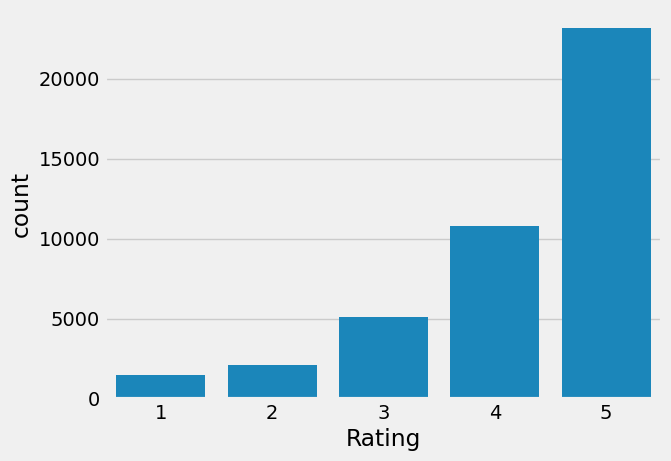

In [7]:
# Create a bar plot with value counts
sns.countplot(x='Rating', data=df)

#### **Part 3. Implementation**

**Objectives**
* Process text data with `nltk` library.
* Draw text topics and determine their numbers.
* Explore topics with `pyLDAvis`.

**References**
* [A Deeper Meaning: Topic Modeling in Python](https://www.toptal.com/python/topic-modeling-python)
* [Hands-On Topic Modeling with Python](https://towardsdatascience.com/hands-on-topic-modeling-with-python-1e3466d406d7)
* [Disneyland Reviews at Kaggle (Data Source)](https://www.kaggle.com/datasets/arushchillar/disneyland-reviews)
* [Python | Lemmatization with NLTK](https://www.geeksforgeeks.org/python-lemmatization-with-nltk/)
* [A friendly guide to NLP: Bag-of-Words with Python example](https://www.analyticsvidhya.com/blog/2021/08/a-friendly-guide-to-nlp-bag-of-words-with-python-example/)

##### **3.1. Loading NLP Libraries**

**A. Natural Language Processing Tools**

In [10]:
# Need to install `gensim' (2025-09-24)
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 15.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompati

In [8]:
# NLP libraries
import nltk
import gensim
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [9]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

##### **3.2. Text Processing**

Here are a few additions to in earlier notebooks:
* Dealing with contractions
* Extending the stop word set by adding contextual terms

**Considering contractions in English**

In [10]:
# A dictionary of main contractions in English
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are",
"you've": "you have"
}

**Extending the stop word set by adding contextual terms**

In [11]:
# Define a basic stop word set
stop_words = set(stopwords.words('english'))

In [12]:
# Extend the stop word set
stop_words.update(['park', 'disney', 'disneyland']) # Context-specific stopwords

**Define a text processing function**

In [13]:
# Bring lemmatizer
lemmatizer = WordNetLemmatizer()

In [14]:
# Define a text pre-processing function
def process_text(text):
    # Lowercasing
    text = text.lower()

    # Expand contractions
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\'', ' ', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords & perform lemmatization
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(filtered_tokens)

In [15]:
# Apply the pre-processing function
df['Review_Clean'] = df['Review_Text'].apply(process_text)
df['Review_Clean']

,Review_Clean
0,ever anywhere find hong kong similar layout walk main street familiar feel o...
1,since last time visit hk yet time stay tomorrowland aka marvel landnow iron ...
2,thanks god hot humid visiting otherwise would big issue lot shadei arrived a...
3,hk great compact unfortunately quite bit maintenance work going present numb...
4,location city took around 1 hour kowlon kid like much everything fine really...
...,...
42651,went paris july 03 thought brilliant visited hotel stayed newport bay also k...
42652,2 adult 1 child 11 visited paris beginning feb 04 absolute fantastic timewe ...
42653,eleven year old daughter went visit son london decided go paris stayed two n...
42654,hotel part paris complex wonderful place family since 3 kid needed room crew...


/tmp/ipython-input-2780139868.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'words', y = 'count', data = _, palette = 'winter')


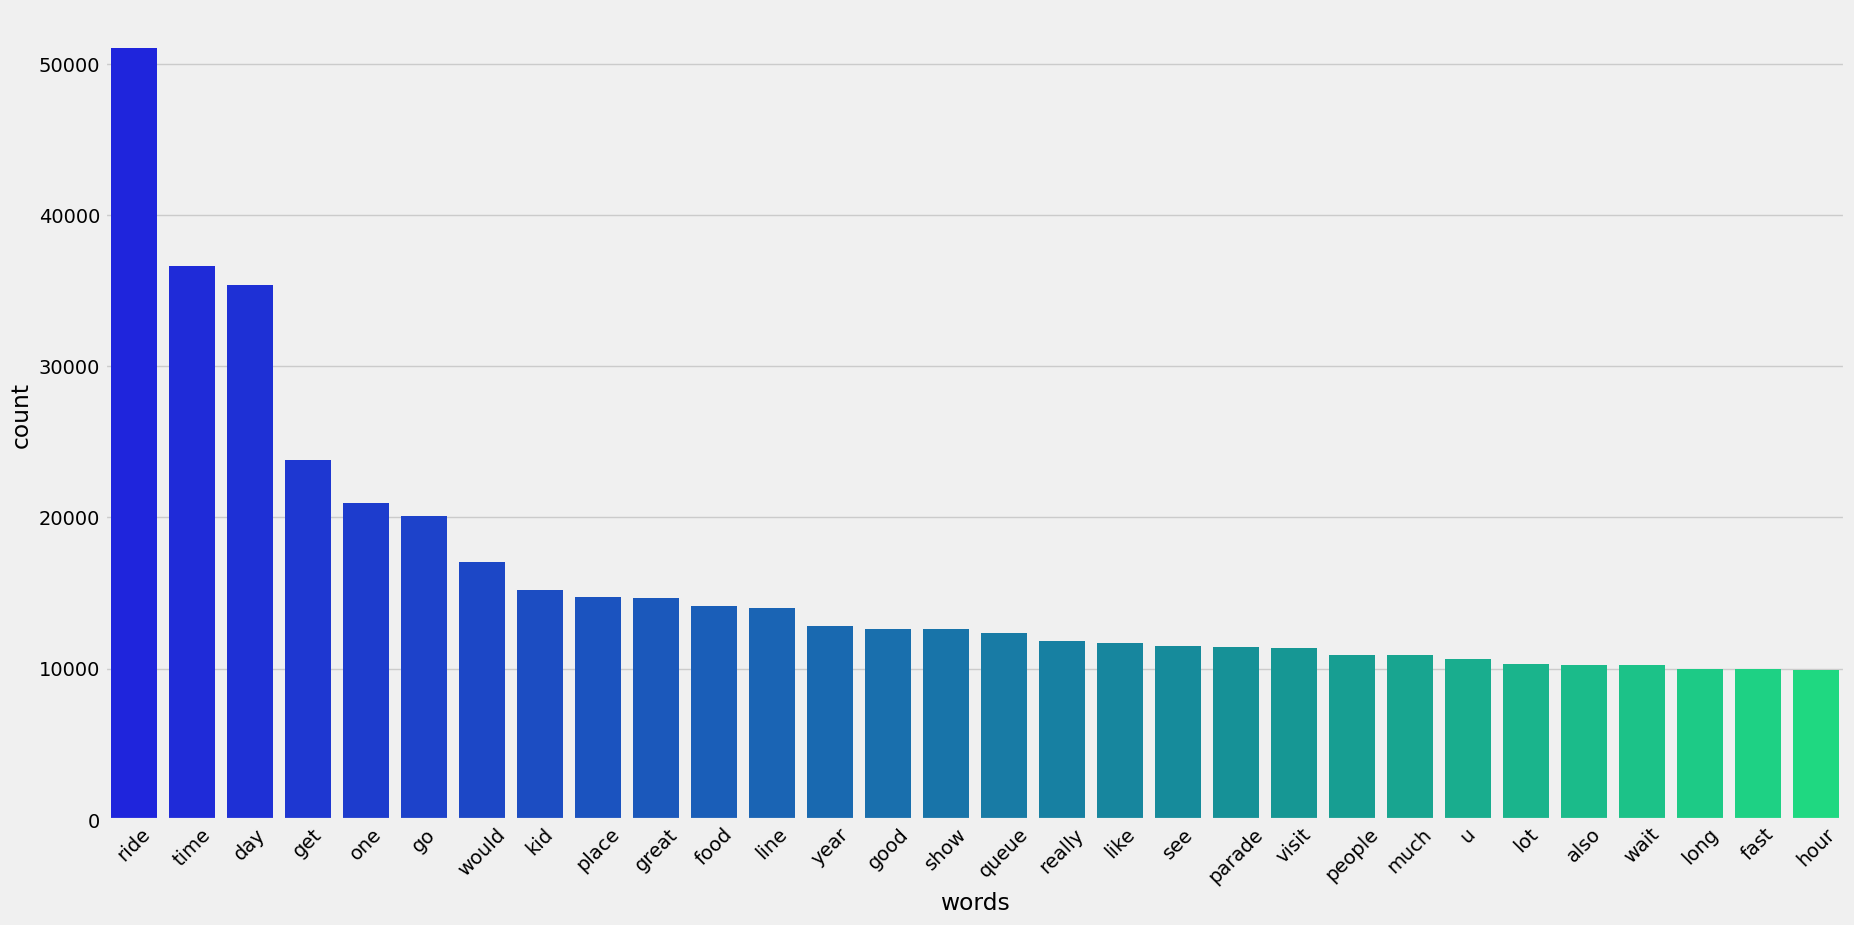

In [16]:
from collections import Counter

# Join text together
review_words = ','.join(list(df['Review_Clean'].values))

# Count each word
Counter = Counter(review_words.split())
most_frequent = Counter.most_common(30)

# Bar plot of frequent words
fig = plt.figure(1, figsize = (20,10))
_ = pd.DataFrame(most_frequent, columns=("words","count"))
sns.barplot(x = 'words', y = 'count', data = _, palette = 'winter')
plt.xticks(rotation=45);

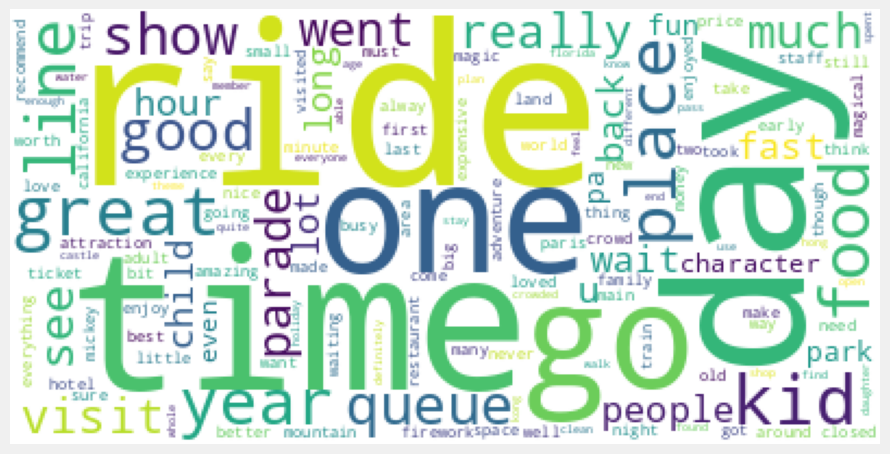

In [17]:
# Generate the word cloud
wordcloud = WordCloud(background_color="white",
                      max_words= 200,
                      contour_width = 8,
                      contour_color = "steelblue",
                      collocations=False).generate(review_words)

# Visualize the word cloud
fig = plt.figure(1, figsize = (10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

##### **3.3. Bag-of-Words**

In order to use text as an input to machine learning algorithms, we need to present it in a numerical format. **Bag-of-words** is a vector space model and represents the occurrence of words in the document. In other words, bag-of-words converts each review into a collection of word counts without giving importance to the order or meaning.

Here are a few example sentences about Game of Thrones:
* Review 1: Game of Thrones is an amazing tv series!
* Review 2: Game of Thrones is the best tv series!
* Review 3: Game of Thrones is so great.

Each row corresponds to a different review, while the rows are the unique words, contained in the three documents.

![Image](https://cdn-images-1.medium.com/max/1000/1*cHKkqYIhaYuYwuuhBiSlHw.png)


In [18]:
# Ensure 'Review_Clean_List' contains tokenized text (lists of words)
df['Review_Clean_List'] = df['Review_Clean'].apply(lambda x: x.split() if isinstance(x, str) else x)


In [19]:
df['Review_Clean_List']

,Review_Clean_List
0,"[ever, anywhere, find, hong, kong, similar, layout, walk, main, street, fami..."
1,"[since, last, time, visit, hk, yet, time, stay, tomorrowland, aka, marvel, l..."
2,"[thanks, god, hot, humid, visiting, otherwise, would, big, issue, lot, shade..."
3,"[hk, great, compact, unfortunately, quite, bit, maintenance, work, going, pr..."
4,"[location, city, took, around, 1, hour, kowlon, kid, like, much, everything,..."
...,...
42651,"[went, paris, july, 03, thought, brilliant, visited, hotel, stayed, newport,..."
42652,"[2, adult, 1, child, 11, visited, paris, beginning, feb, 04, absolute, fanta..."
42653,"[eleven, year, old, daughter, went, visit, son, london, decided, go, paris, ..."
42654,"[hotel, part, paris, complex, wonderful, place, family, since, 3, kid, neede..."


In [20]:
# Create Dictionary
id2word = gensim.corpora.Dictionary(df['Review_Clean_List'])

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in df['Review_Clean_List']]

##### **3.4. Determining the Number of Topics**

Deciding on the number of topics for the topic modeling can be difficult. Since we have initial knowledge of the context, determining the number of topics for modeling wouldn't be too outraging. However, if this number is too much then the model might fail to detect a topic that is actually broader and if this number is too less then topics might have large overlapping words. Because of these reasons, we will use the topic coherence score.

In [21]:
# Compute coherence score
from gensim.models import CoherenceModel

# By the number of topics from 1 to 7 (~1 min per each)
number_of_topics = []
coherence_score = []
for i in range(1,8):
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, iterations=50, num_topics=i)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=df['Review_Clean_List'], dictionary=id2word, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  number_of_topics.append(i)
  coherence_score.append(coherence_lda);

In [22]:
# Create a dataframe of coherence score by number of topics
topic_coherence = pd.DataFrame({'number_of_topics':number_of_topics,
                                'coherence_score':coherence_score})

<Axes: xlabel='number_of_topics', ylabel='coherence_score'>

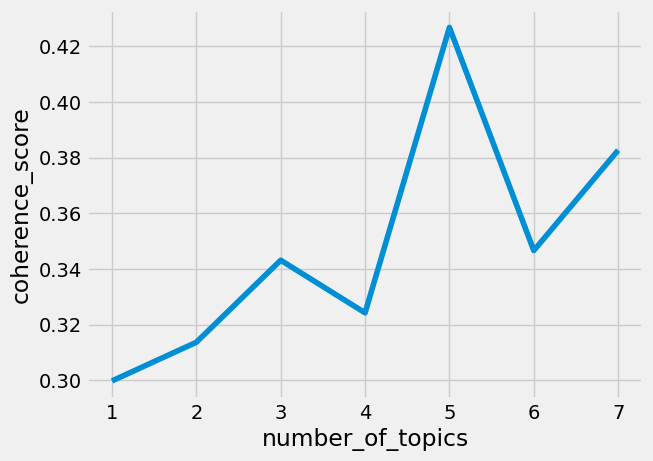

In [23]:
# Print a line plot
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score')

In [24]:
# Explore words occurring in each topic with their relative weight
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))
    print("\n")

Topic: 0 Word: 0.028*"ride" + 0.018*"paris" + 0.014*"mountain" + 0.012*"park" + 0.010*"time" + 0.009*"florida" + 0.009*"one" + 0.008*"world" + 0.008*"space" + 0.008*"like"


Topic: 1 Word: 0.014*"staff" + 0.012*"people" + 0.012*"u" + 0.008*"would" + 0.007*"one" + 0.007*"could" + 0.006*"service" + 0.006*"child" + 0.006*"food" + 0.005*"like"


Topic: 2 Word: 0.022*"parade" + 0.020*"show" + 0.018*"great" + 0.018*"character" + 0.015*"amazing" + 0.014*"ride" + 0.011*"day" + 0.011*"place" + 0.010*"see" + 0.010*"magical"


Topic: 3 Word: 0.025*"place" + 0.022*"time" + 0.019*"year" + 0.017*"go" + 0.015*"kid" + 0.014*"love" + 0.014*"jones" + 0.013*"indiana" + 0.013*"visit" + 0.011*"great"


Topic: 4 Word: 0.028*"train" + 0.022*"mickey" + 0.017*"station" + 0.016*"de" + 0.014*"village" + 0.011*"rer" + 0.010*"mouse" + 0.007*"minnie" + 0.007*"marne" + 0.007*"captain"


Topic: 5 Word: 0.020*"ride" + 0.018*"day" + 0.017*"time" + 0.014*"get" + 0.011*"queue" + 0.010*"go" + 0.009*"one" + 0.008*"hotel" +

##### **3.5. Getting Topic Weights with the Optimal Number**

In [25]:
# Define LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, iterations=50, num_topics=5)

# Compute topic distributions for each document in the corpus
lda_topics = [lda_model.get_document_topics(doc, minimum_probability=0) for doc in corpus]

# Convert topic distributions into a DataFrame
topic_weights = pd.DataFrame([[topic_prob for _, topic_prob in doc] for doc in lda_topics],
                             columns=[f"Topic_{i}" for i in range(lda_model.num_topics)])

# Merge topic weights with original DataFrame
df_with_topics = pd.concat([df['Review_Clean_List'], topic_weights], axis=1)

In [26]:
# Check the results
df_with_topics

,Review_Clean_List,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,"[ever, anywhere, find, hong, kong, similar, layout, walk, main, street, fami...",0.006848,0.006900,0.006826,0.006781,0.972646
1,"[since, last, time, visit, hk, yet, time, stay, tomorrowland, aka, marvel, l...",0.108529,0.566914,0.135644,0.186676,0.002237
2,"[thanks, god, hot, humid, visiting, otherwise, would, big, issue, lot, shade...",0.688034,0.002682,0.002678,0.002688,0.303917
3,"[hk, great, compact, unfortunately, quite, bit, maintenance, work, going, pr...",0.177390,0.004695,0.064426,0.317032,0.436458
4,"[location, city, took, around, 1, hour, kowlon, kid, like, much, everything,...",0.330954,0.011922,0.012048,0.011952,0.633123
...,...,...,...,...,...,...
42651,"[went, paris, july, 03, thought, brilliant, visited, hotel, stayed, newport,...",0.673551,0.002546,0.002539,0.002937,0.318426
42652,"[2, adult, 1, child, 11, visited, paris, beginning, feb, 04, absolute, fanta...",0.879741,0.002241,0.002254,0.002247,0.113518
42653,"[eleven, year, old, daughter, went, visit, son, london, decided, go, paris, ...",0.633431,0.108907,0.004046,0.004048,0.249568
42654,"[hotel, part, paris, complex, wonderful, place, family, since, 3, kid, neede...",0.391604,0.003333,0.003391,0.368703,0.232969


**Let's create some variables with topics!**

In [27]:
# Ensure the necessary columns exist in the DataFrame
topic_columns = ['Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4']

# Compute mean and variance of the five topic columns
df_with_topics['Topic_Mean'] = df_with_topics[topic_columns].mean(axis=1)
df_with_topics['Topic_Variance'] = df_with_topics[topic_columns].var(axis=1)

# Display the updated DataFrame
df_with_topics

,Review_Clean_List,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_Mean,Topic_Variance
0,"[ever, anywhere, find, hong, kong, similar, layout, walk, main, street, fami...",0.006848,0.006900,0.006826,0.006781,0.972646,0.2,0.186557
1,"[since, last, time, visit, hk, yet, time, stay, tomorrowland, aka, marvel, l...",0.108529,0.566914,0.135644,0.186676,0.002237,0.2,0.046606
2,"[thanks, god, hot, humid, visiting, otherwise, would, big, issue, lot, shade...",0.688034,0.002682,0.002678,0.002688,0.303917,0.2,0.091445
3,"[hk, great, compact, unfortunately, quite, bit, maintenance, work, going, pr...",0.177390,0.004695,0.064426,0.317032,0.436458,0.2,0.031661
4,"[location, city, took, around, 1, hour, kowlon, kid, like, much, everything,...",0.330954,0.011922,0.012048,0.011952,0.633123,0.2,0.077701
...,...,...,...,...,...,...,...,...
42651,"[went, paris, july, 03, thought, brilliant, visited, hotel, stayed, newport,...",0.673551,0.002546,0.002539,0.002937,0.318426,0.2,0.088772
42652,"[2, adult, 1, child, 11, visited, paris, beginning, feb, 04, absolute, fanta...",0.879741,0.002241,0.002254,0.002247,0.113518,0.2,0.146712
42653,"[eleven, year, old, daughter, went, visit, son, london, decided, go, paris, ...",0.633431,0.108907,0.004046,0.004048,0.249568,0.2,0.068853
42654,"[hotel, part, paris, complex, wonderful, place, family, since, 3, kid, neede...",0.391604,0.003333,0.003391,0.368703,0.232969,0.2,0.035898
